<a href="https://colab.research.google.com/github/kinfo2009/AIProject/blob/main/srgan_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

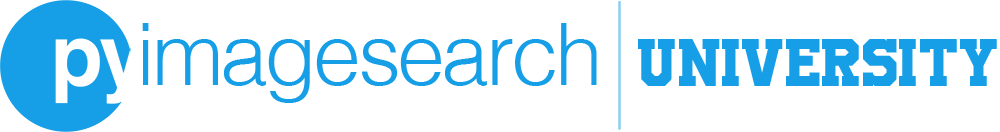

# Super-Resolution Generative Adversarial Networks (SRGAN)
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Super-Resolution Generative Adversarial Networks (SRGAN)](https://pyimg.co/lgnrx) blog post published on 2022-06-06.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*PyImageSearch Team*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2022 OptiReto, LLC and PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/srgan/srgan.zip
!unzip -qq srgan.zip
%cd srgan

--2022-06-15 05:25:56--  https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/srgan/srgan.zip
Resolving pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)... 52.218.204.73
Connecting to pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)|52.218.204.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32528237 (31M) [application/zip]
Saving to: ‘srgan.zip’

srgan.zip           100%[===================>]  31.02M  40.3MB/s    in 0.8s    

2022-06-15 05:25:57 (40.3 MB/s) - ‘srgan.zip’ saved [32528237/32528237]

/content/srgan


## Blog Post Code

### Import Packages

In [ ]:
# import the necessary packages
from pyimagesearch.data_preprocess import load_dataset
from pyimagesearch.utils import zoom_into_images
from pyimagesearch import config
from tensorflow import distribute
from tensorflow.config import experimental_connect_to_cluster
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.io.gfile import glob
from tensorflow.io import serialize_tensor
from tensorflow.io import TFRecordWriter
from tensorflow.train import BytesList
from tensorflow.train import Feature
from tensorflow.train import Features
from tensorflow.train import Example
from matplotlib.pyplot import subplots
import tensorflow_datasets as tfds
import tensorflow as tf
import argparse
import sys
import os

# define AUTOTUNE object
AUTO = tf.data.AUTOTUNE

### Generating Testing Dataset TFRecords

In [ ]:
def pre_process(element):
	# grab the low and high resolution images
	lrImage = element["lr"]
	hrImage = element["hr"]

	# convert the low and high resolution images from tensor to
	# serialized TensorProto proto
	lrByte = serialize_tensor(lrImage)
	hrByte = serialize_tensor(hrImage)

	# return the low and high resolution proto objects
	return (lrByte, hrByte)

def create_dataset(dataDir, split, shardSize):
	# load the dataset, save it to disk, and preprocess it
	ds = tfds.load(config.DATASET, split=split, data_dir=dataDir)
	ds = (ds
		.map(pre_process, num_parallel_calls=AUTO)
		.batch(shardSize)
	)

	# return the dataset
	return ds

def create_serialized_example(lrByte, hrByte):
	# create low and high resolution image byte list
	lrBytesList = BytesList(value=[lrByte])
	hrBytesList = BytesList(value=[hrByte])

	# build low and high resolution image feature from the byte list
	lrFeature = Feature(bytes_list=lrBytesList)
	hrFeature = Feature(bytes_list=hrBytesList)

	# build a low and high resolution image feature map
	featureMap = {
		"lr": lrFeature,
		"hr": hrFeature,
	}

	# build a collection of features, followed by building example
	# from features, and serializing the example
	features = Features(feature=featureMap)
	example = Example(features=features)
	serializedExample = example.SerializeToString()

	# return the serialized example
	return serializedExample

def prepare_tfrecords(dataset, outputDir, name, printEvery=50):
	# check whether output directory exists
	if not os.path.exists(outputDir):
		os.makedirs(outputDir)

	# loop over the dataset and create TFRecords
	for (index, images) in enumerate(dataset):
		# get the shard size and build the filename
		shardSize = images[0].numpy().shape[0]
		tfrecName = f"{index:02d}-{shardSize}.tfrec"
		filename = outputDir + f"/{name}-" + tfrecName

		# write to the tfrecords
		with TFRecordWriter(filename) as outFile:
			# write shard size serialized examples to each TFRecord
			for i in range(shardSize):
				serializedExample = create_serialized_example(
					images[0].numpy()[i], images[1].numpy()[i])
				outFile.write(serializedExample)

			# print the progress to the user
			if index % printEvery == 0:
				print("[INFO] wrote file {} containing {} records..."
				.format(filename, shardSize))

In [ ]:
# create test dataset of the div2k images
print("[INFO] creating div2k testing dataset...")
testDs = create_dataset(dataDir=config.DIV2K_PATH, split="validation",
	shardSize=config.SHARD_SIZE)

# create testing TFRecords and write them to disk
print("[INFO] preparing and writing div2k TFRecords to disk...")
prepare_tfrecords(dataset=testDs, name="test",
	outputDir=config.GPU_DIV2K_TFR_TEST_PATH)

[INFO] creating div2k testing dataset...
EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/div2k/div2k/bicubic_x4/2.0.0.incompleteUO86L7/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/div2k/div2k/bicubic_x4/2.0.0.incompleteUO86L7/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to dataset/div2k/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
[INFO] preparing and writing div2k TFRecords to disk...
[INFO] wrote file tfrecord/test/test-00-100.tfrec containing 100 records...


### Performing inference with SRGAN

In [ ]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("--device", required=True, default="gpu",
#	choices=["gpu", "tpu"], type=str,
#	help="device to use for training (gpu or tpu)")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"device": "gpu"
}

In [ ]:
# check if we are using TPU, if so, initialize the strategy
# accordingly
if args["device"] == "tpu":
	# initialize the tpus
	tpu = distribute.cluster_resolver.TPUClusterResolver()
	experimental_connect_to_cluster(tpu)
	initialize_tpu_system(tpu)
	strategy = distribute.TPUStrategy(tpu)

	# ensure the user has entered a valid gcs bucket path
	if config.TPU_BASE_TFR_PATH == "gs://<PATH_TO_GCS_BUCKET>/tfrecord":
		print("[INFO] not a valid GCS Bucket path...")
		sys.exit(0)

	# set the train TFRecords, pretrained generator, and final
	# generator model paths to be used for TPU training
	tfrTestPath = config.TPU_DIV2K_TFR_TEST_PATH
	pretrainedGenPath = config.TPU_PRETRAINED_GENERATOR_MODEL
	genPath = config.TPU_GENERATOR_MODEL

# otherwise, we are using multi/single GPU so initialize the mirrored
# strategy
elif args["device"] == "gpu":
	# define the multi-gpu strategy
	strategy = distribute.MirroredStrategy()

	# set the train TFRecords, pretrained generator, and final
	# generator model paths to be used for GPU training
	tfrTestPath = config.GPU_DIV2K_TFR_TEST_PATH
	pretrainedGenPath = config.GPU_PRETRAINED_GENERATOR_MODEL
	genPath = config.GPU_GENERATOR_MODEL

# else, invalid argument was provided as input
else:
	# exit the program
	print("[INFO] please enter a valid device argument...")
	sys.exit(0)

In [ ]:
# get the dataset
print("[INFO] loading the test dataset...")
testTfr = glob(tfrTestPath + "/*.tfrec")
testDs = load_dataset(testTfr, config.INFER_BATCH_SIZE, train=False)

# get the first batch of testing images
(lrImage, hrImage) = next(iter(testDs))

# call the strategy scope context manager
with strategy.scope():
	# load the SRGAN trained models
	print("[INFO] loading the pre-trained and fully trained SRGAN model...")
	srganPreGen = load_model(pretrainedGenPath, compile=False)
	srganGen = load_model(genPath, compile=False)

	# predict using SRGAN
	print("[INFO] making predictions with pre-trained and fully trained SRGAN model...")
	srganPreGenPred = srganPreGen.predict(lrImage)
	srganGenPred = srganGen.predict(lrImage)

[INFO] plotting the SRGAN predictions...


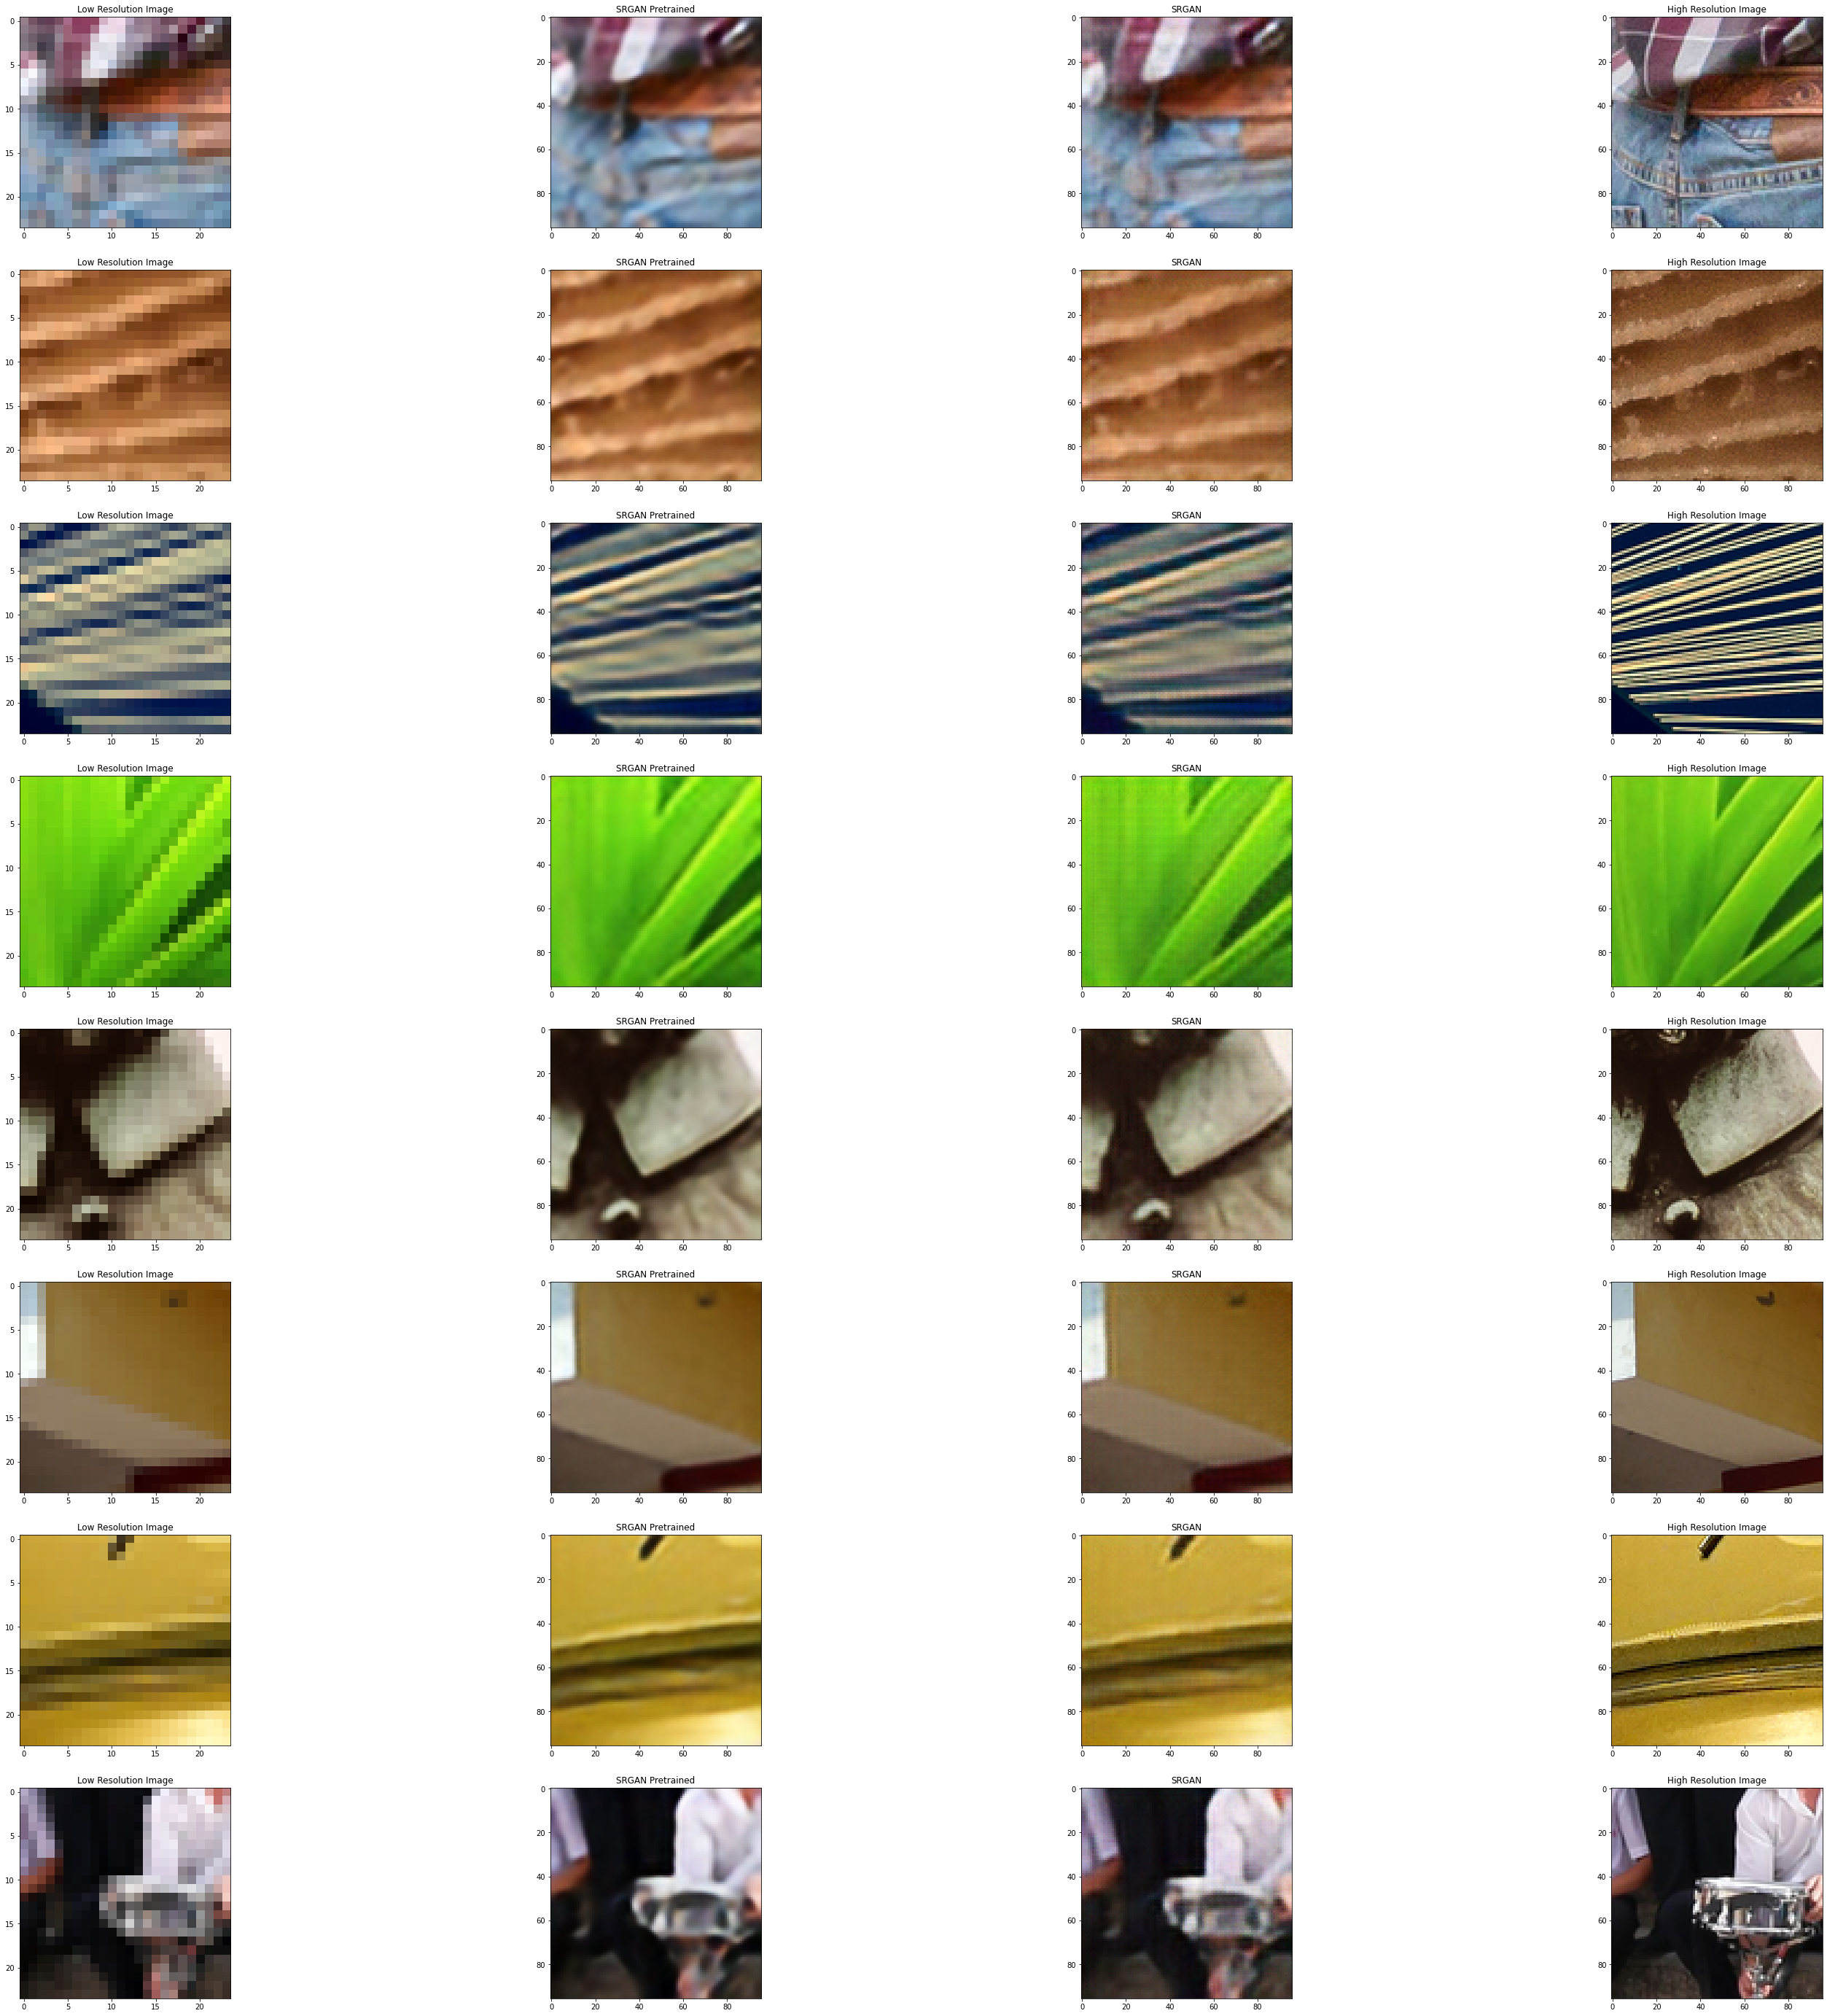

In [ ]:
# plot the respective predictions
print("[INFO] plotting the SRGAN predictions...")
(fig, axes) = subplots(nrows=config.INFER_BATCH_SIZE, ncols=4,
	figsize=(50, 50))

# plot the predicted images from low res to high res
for (ax, lowRes, srPreIm, srGanIm, highRes) in zip(axes, lrImage,
		srganPreGenPred, srganGenPred, hrImage):
	# plot the low resolution image
	ax[0].imshow(array_to_img(lowRes))
	ax[0].set_title("Low Resolution Image")

	# plot the pretrained SRGAN image
	ax[1].imshow(array_to_img(srPreIm))
	ax[1].set_title("SRGAN Pretrained")

	# plot the SRGAN image
	ax[2].imshow(array_to_img(srGanIm))
	ax[2].set_title("SRGAN")

	# plot the high resolution image
	ax[3].imshow(array_to_img(highRes))
	ax[3].set_title("High Resolution Image")

[INFO] saving the SRGAN predictions to disk...


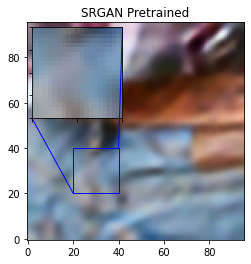

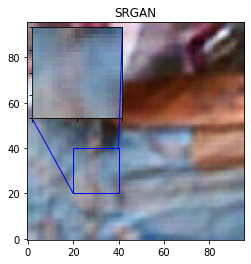

In [ ]:
# check whether output image directory exists, if it doesn't, then
# create it
if not os.path.exists(config.BASE_IMAGE_PATH):
	os.makedirs(config.BASE_IMAGE_PATH)

# serialize the results to disk
print("[INFO] saving the SRGAN predictions to disk...")
fig.savefig(config.GRID_IMAGE_PATH)

# plot the zoomed in images
zoom_into_images(srganPreGenPred[0], "SRGAN Pretrained")
zoom_into_images(srganGenPred[0], "SRGAN")

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Super-Resolution Generative Adversarial Networks (SRGAN)*](https://pyimg.co/lgnrx) published on 2022-06-06.

# Code License Agreement
```
Copyright (c) 2022 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from OptiReto, LLC and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```